In [15]:
import pandas as pd

df = pd.read_csv('src/thwiki.csv')

df = df[~df.text.isna()]
txt = '\n'.join(df.text.values)

with open('src/thwiki.txt','w') as f:
    f.write(txt)
    f.close()

In [42]:
# some text clean up
src_file = Path('src/thwiki.txt')
lines = src_file.read_text(encoding='utf-8').splitlines()
len(lines)

944329

In [43]:
# get rid of topic/header text 
lines = [line for line in lines if ' ' in line]
len(lines)

690987

In [51]:
txt = '\n'.join(lines)

with open('src/thwiki_clean.txt','w') as f:
    f.write(txt)
    f.close()

In [52]:
from pathlib import Path
from tokenizers import ByteLevelBPETokenizer
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

In [53]:
%%time 
tokenizer = ByteLevelBPETokenizer()

tokenizer.train(files=['src/thwiki_clean.txt'], vocab_size=20_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

CPU times: user 7min 54s, sys: 43.2 s, total: 8min 37s
Wall time: 5min 2s


In [54]:
tokenizer.save("ThaiBert")

['ThaiBert/vocab.json', 'ThaiBert/merges.txt']

In [55]:
tokenizer = ByteLevelBPETokenizer(
    "./ThaiBert/vocab.json",
    "./ThaiBert/merges.txt",
)

In [56]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

In [57]:
test_txt = "สวัสดีชาวโลก วันนี้เราจะมาเทรน model BERT กันโดยใช้ library Huggingface"
tokenizer.encode(test_txt).tokens

['<s>',
 'à¸ªà¸§',
 'à¸±',
 'à¸ªà¸Ķ',
 'à¸µ',
 'à¸Ĭà¸²à¸§',
 'à¹Ĥà¸¥à¸ģ',
 'Ġà¸§',
 'à¸±',
 'à¸Ļà¸Ļ',
 'à¸µà¹ī',
 'à¹Ģà¸£à¸²à¸Īà¸°',
 'à¸¡à¸²',
 'à¹Ģà¸Ĺà¸£',
 'à¸Ļ',
 'Ġmod',
 'el',
 'ĠB',
 'ER',
 'T',
 'Ġà¸ģ',
 'à¸±',
 'à¸Ļà¹Ĥà¸Ķà¸¢à¹ĥà¸Ĭ',
 'à¹ī',
 'Ġli',
 'br',
 'ary',
 'ĠH',
 'ug',
 'g',
 'ing',
 'face',
 '</s>']

In [58]:
tokenizer.decode(tokenizer.encode(test_txt).ids)

'<s>สวัสดีชาวโลก วันนี้เราจะมาเทรน model BERT กันโดยใช้ library Huggingface</s>'

In [71]:
import json

# preparing model config
config = {
    "architectures": [
        "RobertaForMaskedLM"
    ],
    "max_position_embeddings": 514,
    "vocab_size": 25_000
}
with open("./ThaiBert/config.json", 'w') as fp:
    json.dump(config, fp)

# preparing tokenizer config
tokenizer_config = {
    "max_len": 512
}
with open("./ThaiBert/tokenizer_config.json", 'w') as fp:
    json.dump(tokenizer_config, fp)

# preparing train command
cmd ="""
#! /bin/bash
python run_language_modeling.py
--train_data_file ./src/thwiki.txt
--output_dir ./ThaiBertModel
--model_type roberta
--mlm
--config_name ./ThaiBert
--tokenizer_name ./ThaiBert
--do_train
--learning_rate 1e-4
--pct_warmup 0.3
--num_train_epochs 10
--save_total_limit 2
--save_steps 2000
--per_gpu_train_batch_size 16
""".replace("\n", " ")

with open('./train-model','w') as fp:
    fp.write(cmd)

# Find learning rate

In [80]:
import argparse
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

In [69]:
MODEL_CLASSES = {
    "gpt2": (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    "openai-gpt": (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    "bert": (BertConfig, BertForMaskedLM, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForMaskedLM, CamembertTokenizer),
}

In [70]:
# load model & tokenizer class
config_class, model_class, tokenizer_class = MODEL_CLASSES["roberta"]

In [72]:
# load model config from .json file
config = config_class.from_pretrained('./ThaiBert', cache_dir=None)

I0323 06:42:33.139810 4364248512 configuration_utils.py:277] loading configuration file ./ThaiBert/config.json
I0323 06:42:33.141808 4364248512 configuration_utils.py:315] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "min_length": 0,
  "model_type": "roberta",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "nu

In [73]:
# load tokenizer
tokenizer = tokenizer_class.from_pretrained('./ThaiBert', cache_dir=None)

I0323 06:44:24.790025 4364248512 tokenization_utils.py:420] Model name './ThaiBert' not found in model shortcut name list (roberta-base, roberta-large, roberta-large-mnli, distilroberta-base, roberta-base-openai-detector, roberta-large-openai-detector). Assuming './ThaiBert' is a path, a model identifier, or url to a directory containing tokenizer files.
I0323 06:44:24.791359 4364248512 tokenization_utils.py:449] Didn't find file ./ThaiBert/added_tokens.json. We won't load it.
I0323 06:44:24.793643 4364248512 tokenization_utils.py:449] Didn't find file ./ThaiBert/special_tokens_map.json. We won't load it.
I0323 06:44:24.794605 4364248512 tokenization_utils.py:502] loading file ./ThaiBert/vocab.json
I0323 06:44:24.795073 4364248512 tokenization_utils.py:502] loading file ./ThaiBert/merges.txt
I0323 06:44:24.795552 4364248512 tokenization_utils.py:502] loading file None
I0323 06:44:24.796000 4364248512 tokenization_utils.py:502] loading file None
I0323 06:44:24.796465 4364248512 tokeniza

In [77]:
block_size = tokenizer.max_len

In [75]:
# load model
model = model_class(config=config)

In [82]:
class LineByLineTextDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, file_path: str, block_size=512):
        assert os.path.isfile(file_path)
        # Here, we do not cache the features, operating under the assumption
        # that we will soon use fast multithreaded tokenizers from the
        # `tokenizers` repo everywhere =)

        with open(file_path, encoding="utf-8") as f:
            lines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

        self.examples = tokenizer.batch_encode_plus(lines, add_special_tokens=True, max_length=block_size)["input_ids"]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i], dtype=torch.long)

In [83]:
file_path = "./src/thwiki.txt"
train_dataset = LineByLineTextDataset(tokenizer, file_path=file_path, block_size=block_size)

In [84]:
train_batch_size = 8
def collate(examples: List[torch.Tensor]):
    if tokenizer._pad_token is None:
        return pad_sequence(examples, batch_first=True)
    return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(
    train_dataset, sampler=train_sampler, batch_size=train_batch_size, collate_fn=collate
)

In [85]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0,
    },
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]

In [86]:
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)

In [158]:
def mask_tokens(inputs: torch.Tensor, tokenizer: PreTrainedTokenizer, mlm_probability) -> Tuple[torch.Tensor, torch.Tensor]:
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [88]:
mlm_probability = .15

In [128]:
inputs, labels = mask_tokens(next(iter(train_dataloader)), tokenizer, mlm_probability)

inputs.shape, labels.shape

(torch.Size([8, 251]), torch.Size([8, 251]))

In [129]:
model(inputs, masked_lm_labels=labels)

(tensor(10.2231, grad_fn=<NllLossBackward>),
 tensor([[[ 4.0184e-01, -2.7890e-01,  8.7586e-01,  ..., -3.0042e-01,
           -2.7622e-01, -7.9671e-01],
          [ 4.3925e-01, -1.1127e+00,  6.7683e-01,  ..., -4.5304e-01,
            9.4325e-01, -8.7863e-01],
          [ 1.0020e+00, -6.9782e-01,  5.9493e-01,  ..., -1.2418e-02,
            3.6302e-01, -4.7675e-01],
          ...,
          [ 3.4202e-01, -5.0038e-01,  7.6054e-01,  ...,  1.0433e-01,
            2.2608e-01, -2.1717e-01],
          [ 2.7688e-01, -9.8598e-01,  9.2853e-01,  ...,  2.0952e-02,
            2.2493e-01,  1.5478e-01],
          [-4.5333e-01, -5.9684e-01,  1.0654e+00,  ..., -1.5712e-01,
            2.1360e-01, -2.1896e-01]],
 
         [[-2.6811e-01, -4.5348e-01, -1.4080e-02,  ..., -4.0266e-01,
           -4.2741e-01, -3.0381e-01],
          [ 5.1049e-01,  5.3902e-02,  7.5591e-01,  ..., -1.1826e-01,
           -1.5787e-01, -4.0453e-01],
          [ 6.3732e-01, -1.3881e+00, -4.5012e-01,  ..., -1.0668e-01,
            

In [159]:
class CancelTrainException(Exception): pass

class BertLRFinder:
    def __init__(self, model, tokenizer, data_loader, bs, opt, lr_range=[1e-7,1], max_iter=500):
        self.lrs = []
        self.losses = []
        self.model = model
        self.tokenizer = tokenizer
        self.data_loader = data_loader
        self.bs = bs
        self.opt = opt
        self.lr_range = lr_range
        self.max_iter = max_iter
    
    def run(self):
        best_loss = np.inf
        i = 0
        while i<self.max_iter:
            for batch in self.data_loader:
                # get masked input and label
                inputs, labels = mask_tokens(batch, self.tokenizer, mlm_probability)
                inputs, labels = inputs.to(device), labels.to(device)
                
                # begin batch
                pos = i/self.max_iter
                i+=1
                lr = self.lr_range[0]*(self.lr_range[1]/self.lr_range[0])**pos
                for pg in self.opt.param_groups: pg['lr'] = lr
                
                loss = model(inputs, masked_lm_labels=labels)[0]
                loss.backward()
                self.opt.step()
                self.opt.zero_grad()
              
                # after step
                if (loss.item() > best_loss*10) or (i==self.max_iter): raise CancelTrainException()
                if loss.item() < best_loss: best_loss = loss.item() 

                # after batch
                self.lrs.append(lr)
                self.losses.append(loss.item())
        
    def plot_lr(self):
        # plot lr x loss
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        
    def save_plot(self,dir=Path("."), fig_name="lr_x_loss.png"):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        plt.savefig(dir/fig_name)

In [160]:
lr_finder = BertLRFinder(model=model, tokenizer=tokenizer, data_loader=train_dataloader, bs=8, opt=optimizer,
                        lr_range=[1e-7,1], max_iter=500)

In [162]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [163]:
lr_finder.run()

CancelTrainException: 

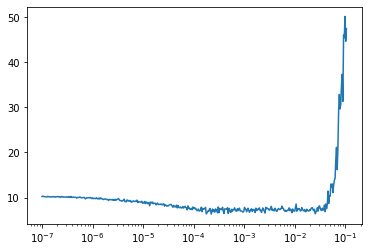

In [164]:
lr_finder.plot_lr()